In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
import geopy.distance
import folium
import matplotlib.pyplot as plt

from scipy.stats.stats import pearsonr
sns.set( rc={'figure.figsize': (15, 8)})

Cargamos los datos de las estaciones dadas

In [2]:
estaciones_info = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'INFO')
estaciones_maximos = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Maximos', index_col = 0, skiprows = 1)
estaciones_anuales = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Anuales', index_col = 0, skiprows = 1)
estaciones_np95 = pd.read_excel('data/Estaciones.xlsx', sheet_name = 'Np95', index_col = 0, skiprows = 1)

In [3]:
datos_ncep_ncar_info = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'INFO')
datos_ncep_ncar_info['LATITUD (°S)'] = datos_ncep_ncar_info['LATITUD (°S)'].astype(np.float32)
datos_ncep_ncar_info['LONGITUD (°W)'] = datos_ncep_ncar_info['LONGITUD (°W)'].astype(np.float32)

datos_ncep_ncar_total = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Total', index_col = 0)
datos_ncep_ncar_maximo = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Maximo', index_col = 0)#
datos_ncep_ncar_np95 = pd.read_excel('data/datos NCEP NCAR.xlsx', sheet_name = 'Np95', index_col = 0)

In [4]:
var_ndefm = pd.read_excel('data/variables e indices NDEFM.xlsx', index_col = 0, usecols = 'A:G')

In [5]:
datos_ncep_ncar_info.set_index('INDICATIVO', drop=True, inplace=True)

Utilizando el módulo folium, graficamos los puntos de las estaciones dadas y los puntos de la grilla proporcionados correspondientes a los puntos dato donde se aplicó el modelo NCEP-NCAR

In [6]:
mapa_noa = folium.Map(location=[-28, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [7]:
for idx, (estacion, _prov, _org, coordenadas, *_) in estaciones_info.iterrows():
    lat, lon = coordenadas.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=estacion, icon=folium.Icon(color='red'))
    marker.add_to(mapa_noa)

In [8]:
for idx, (lat, lon) in datos_ncep_ncar_info.iterrows():
    marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
    marker.add_to(mapa_noa)

In [9]:
mapa_noa

Se calculó posteriormente la estación más cercana punto de la grilla y la distancia a la misma

In [10]:
def nearest(v,est):
    nearest = []
    for index, row in v.iterrows():
        coords_1 = row[['LATITUD (°S)', 'LONGITUD (°W)']].values
        dist = []
        for estation in est.iterrows():
            coords_2 = (estation[1][0],estation[1][1])
            dist.append(geopy.distance.vincenty(coords_1, coords_2).km)
        nearest.append([est.index[np.where(dist == np.amin(dist))[0][0]],np.amin(dist)])
    return nearest                

In [11]:
estacion = []
for _, row in estaciones_info.iterrows():
    new_row = [row['Estacion']]
    new_row.extend(row['LAT (S), LONG (W)(º)'].split(','))
    estacion.append(new_row)
estacion = pd.DataFrame(estacion, columns=['Estacion', 'lat', 'long'])
estacion.set_index('Estacion', drop=True, inplace=True)
estacion['lat']  = estacion['lat'].astype(np.float32)
estacion['long']  = estacion['long'].astype(np.float32)

In [12]:
nearest_station = [i[0] for i in  nearest(datos_ncep_ncar_info, estacion)]
nearest_distance = [i[1] for i in  nearest(datos_ncep_ncar_info, estacion)]
datos_ncep_ncar_info['estacion_cercana'] = nearest_station
datos_ncep_ncar_info['distancia_estacion'] = nearest_distance

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [13]:
datos_ncep_ncar_info

,LATITUD (°S),LONGITUD (°W),estacion_cercana,distancia_estacion
INDICATIVO,,,,
V1,30.0,60.0,La Maria,466.860576
V2,30.0,62.5,La Maria,276.703628
V3,30.0,65.0,Valle Viejo,182.811067
V4,30.0,67.5,Valle Viejo,240.805582
V5,30.0,70.0,Valle Viejo,447.942995
V6,27.5,60.0,La Maria,420.929006
V7,27.5,62.5,La Maria,180.011760
V8,27.5,65.0,Padilla,64.928227
V9,27.5,67.5,Pie de Medano,139.254049


Se agruparon los puntos de la grilla según su estación más cercana y se graficaron los datos

In [14]:
df_max = {}
estaciones_unique = datos_ncep_ncar_info['estacion_cercana'].unique()
for i in estaciones_unique:
    df_max[i] = estaciones_maximos[i]
    for rows in datos_ncep_ncar_info.iterrows():
        if (rows[1]['estacion_cercana'] == i):
            df_max[i] = pd.DataFrame(df_max[i]).join(pd.DataFrame(datos_ncep_ncar_maximo[rows[0]]))
        

In [15]:
df_anuales = {}
estaciones_unique = datos_ncep_ncar_info['estacion_cercana'].unique()
for i in estaciones_unique:
    df_anuales[i] = estaciones_anuales[i]
    for rows in datos_ncep_ncar_info.iterrows():
        if (rows[1]['estacion_cercana'] == i):
            df_anuales[i] = pd.DataFrame(df_anuales[i]).join(pd.DataFrame(datos_ncep_ncar_total[rows[0]]))
        

In [16]:
df_np95 = {}
estaciones_unique = datos_ncep_ncar_info['estacion_cercana'].unique()
for i in estaciones_unique:
    df_np95[i] = estaciones_np95[i]
    for rows in datos_ncep_ncar_info.iterrows():
        if (rows[1]['estacion_cercana'] == i):
            df_np95[i] = pd.DataFrame(df_np95[i]).join(pd.DataFrame(datos_ncep_ncar_np95[rows[0]]))
        

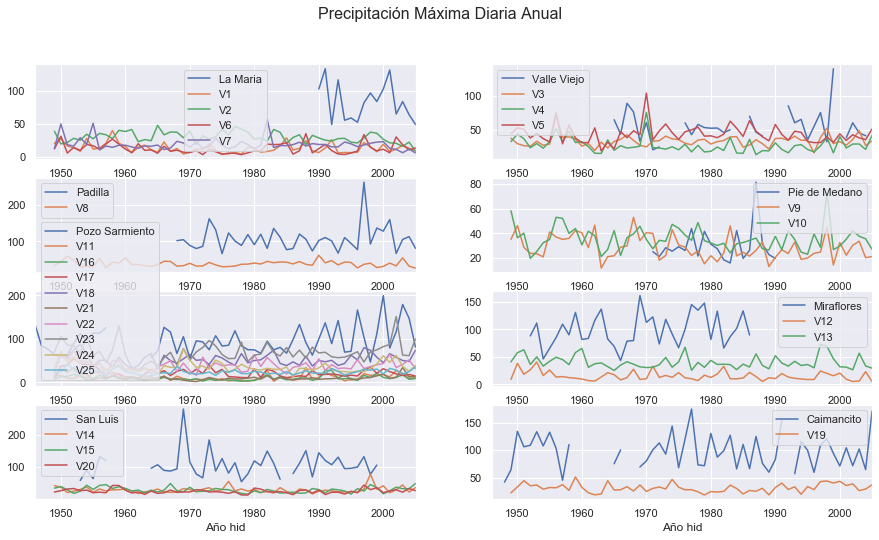

In [75]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('Precipitación Máxima Diaria Anual', fontsize=16 )
df_max['La Maria'].plot(ax=axes[0,0])
df_max['Valle Viejo'].plot(ax=axes[0,1])
df_max['Padilla'].plot(ax=axes[1,0])
df_max['Pie de Medano'].plot(ax=axes[1,1])
df_max['Pozo Sarmiento'].plot(ax=axes[2,0])
df_max['Miraflores'].plot(ax=axes[2,1])
df_max['San Luis'].plot(ax=axes[3,0])
df_max['Caimancito'].plot(ax=axes[3,1])


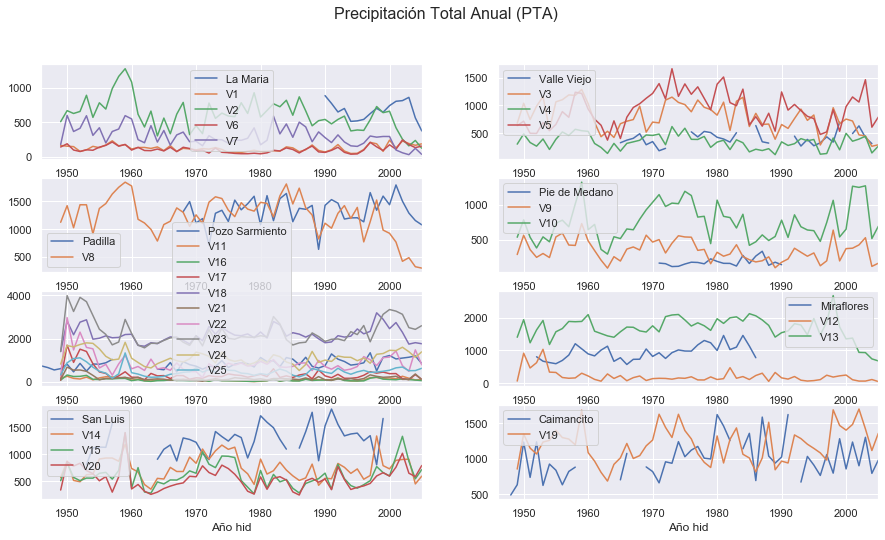

In [76]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('Precipitación Total Anual (PTA)', fontsize=16 )
df_anuales['La Maria'].plot(ax=axes[0,0])
df_anuales['Valle Viejo'].plot(ax=axes[0,1])
df_anuales['Padilla'].plot(ax=axes[1,0])
df_anuales['Pie de Medano'].plot(ax=axes[1,1])
df_anuales['Pozo Sarmiento'].plot(ax=axes[2,0])
df_anuales['Miraflores'].plot(ax=axes[2,1])
df_anuales['San Luis'].plot(ax=axes[3,0])
df_anuales['Caimancito'].plot(ax=axes[3,1])

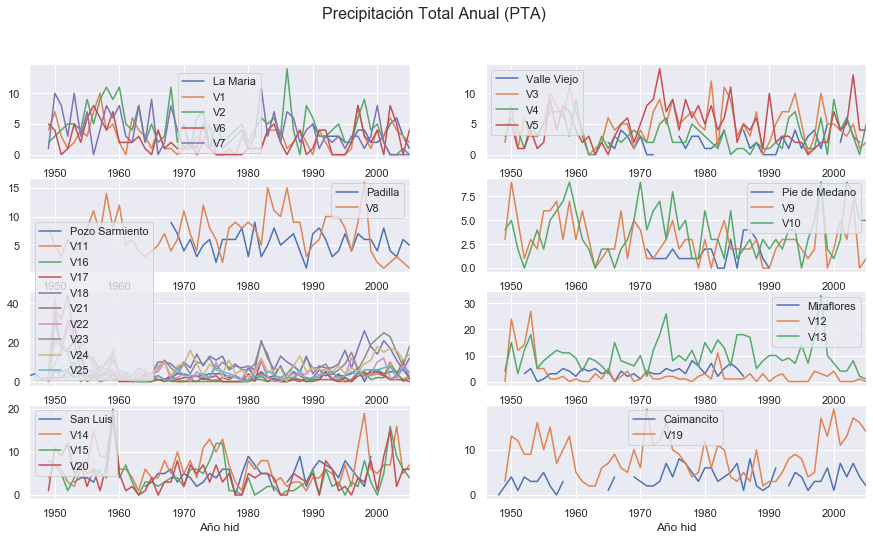

In [77]:
fig, axes = plt.subplots(nrows=4, ncols=2)
fig.suptitle('Precipitación Total Anual (PTA)', fontsize=16 )
df_np95['La Maria'].plot(ax=axes[0,0])
df_np95['Valle Viejo'].plot(ax=axes[0,1])
df_np95['Padilla'].plot(ax=axes[1,0])
df_np95['Pie de Medano'].plot(ax=axes[1,1])
df_np95['Pozo Sarmiento'].plot(ax=axes[2,0])
df_np95['Miraflores'].plot(ax=axes[2,1])
df_np95['San Luis'].plot(ax=axes[3,0])
df_np95['Caimancito'].plot(ax=axes[3,1])

Calculamos el **coeficiente de pearson** de cada punto de la grilla con su estación más cercana

In [20]:
def pearson(df):
    p = {}
    for estacion in df.keys():
        for key in df[estacion].keys():
            x = df[estacion].dropna()[key]
            y = df[estacion].dropna()[estacion]
            if key!=estacion:
                p[key] = pearsonr(x,y)
            
    return p  

In [21]:
def add_distance(df):
    aux = []

    for key in df.keys():
        
        for v in df[key].keys():
            aux.append([datos_ncep_ncar_info.loc[v].distancia_estacion, df[key][v][0]])
        df_aux[key] = aux
    return df_aux

In [22]:
def to_plot(df):
    df_to_plot = pd.DataFrame(columns = [0,1])
    for key in df.keys():
        df_to_plot = df_to_plot.append(pd.DataFrame(df[key]))
    return df_to_plot

In [23]:
pearsons_np95 = pearson(df_np95)
pearsons_max = pearson(df_max)
pearsons_anuales = pearson(df_anuales)

Se grafican a continuación los **histogramas** de los coeficientes de pearson para los distintos grupos de datos

In [24]:
histograma_np95 = []
for key in pearsons_np95.keys():
    histograma_np95.append(pearsons_np95[key][0])

Text(0.5, 1.0, 'Histograma de coeficientes de pearson para datos de Np95')

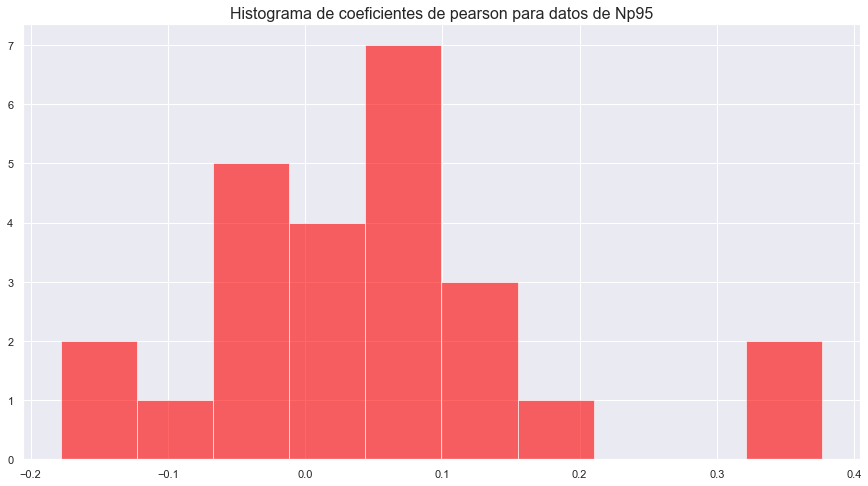

In [78]:
sns.distplot(histograma_np95, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histograma de coeficientes de pearson para datos de Np95', fontsize=16, )

In [70]:
histograma_max = []
for key in pearsons_max.keys():
    histograma_max.append(pearsons_max[key][0])

Text(0.5, 1.0, 'Histograma de coeficientes de pearson para datos de PMDA')

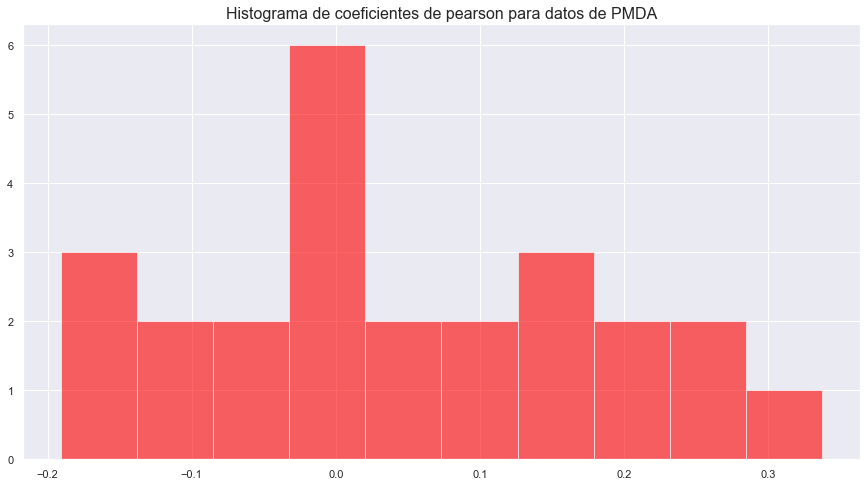

In [79]:
sns.distplot(histograma_max, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histograma de coeficientes de pearson para datos de PMDA', fontsize=16, )

In [72]:
histograma_anuales = []
for key in pearsons_anuales.keys():
    histograma_anuales.append(pearsons_anuales[key][0])

Text(0.5, 1.0, 'Histograma de coeficientes de pearson para datos de PTA')

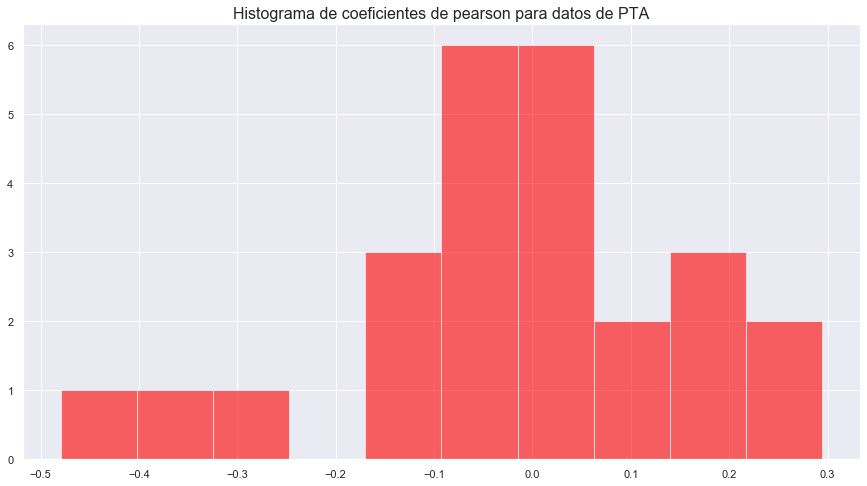

In [80]:
sns.distplot(histograma_anuales, color="red", hist_kws={ "alpha": 0.6}, bins = 10,  kde = False).set_title('Histograma de coeficientes de pearson para datos de PTA', fontsize=16, )

Se observa que para los datos de *Precipitación Total Anual* y *Número de días con Precipitación mayor al percentil 95* los coeficientes de pearson que tienden a ser positivos, mientras que la distribución de los coeficientes de pearson de los datos de *Precipitación Máxima Diaria Anual* es más uniforme, estando esto relacionado con que las variables a modelar numéricamente son variables globales en los 2 primeros casos, mientras en el último caso son valores outlayer. 

In [30]:
distancia_np95 = [datos_ncep_ncar_info.loc[i][3] for i in pearsons_np95.keys()]
distancia_max =  [datos_ncep_ncar_info.loc[i][3] for i in pearsons_max.keys()]
distancia_anuales = [datos_ncep_ncar_info.loc[i][3] for i in pearsons_anuales.keys()]

Graficamos ahora el pearson vs la distancia a la estación más cercana

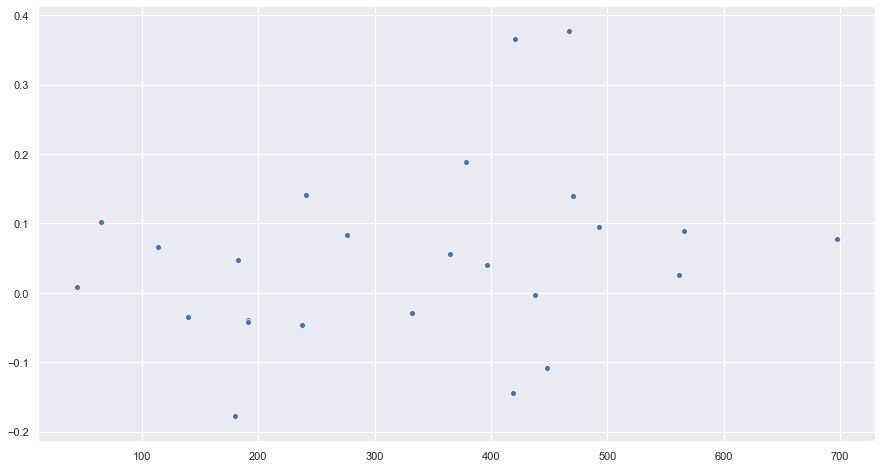

In [81]:
sns.scatterplot(x=distancia_np95, y = histograma_np95 )

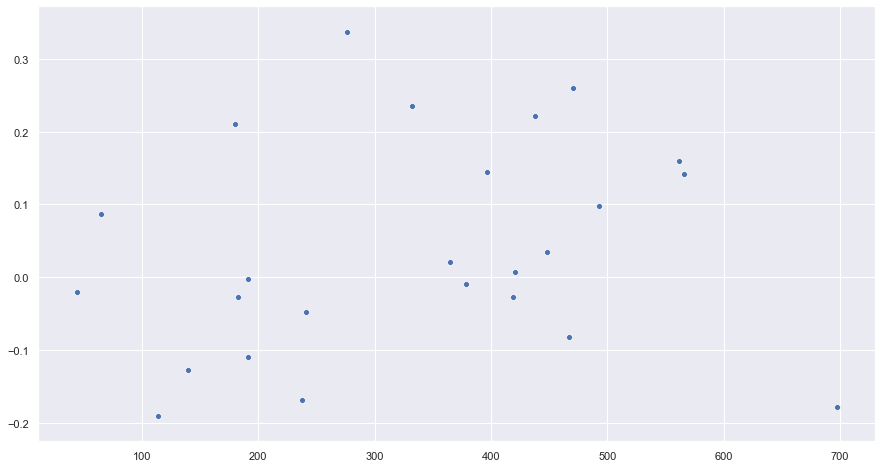

In [82]:
sns.scatterplot(x=distancia_max, y = histograma_max )

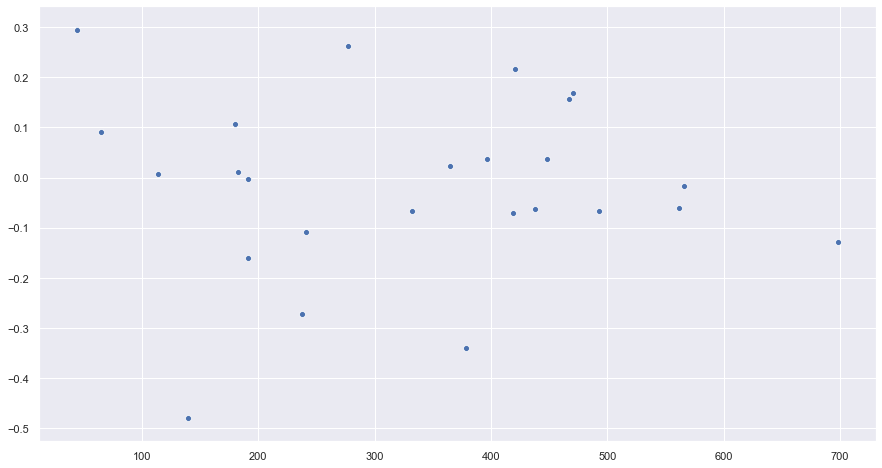

In [83]:
sns.scatterplot(x=distancia_anuales, y = histograma_anuales )

In [34]:
distances_np95 = {}
for i in df_np95.keys():
    a = df_np95[i].dropna()
    main_distance = a[a.columns[0]].sum()
    distances_np95[i] = {}
    for cols in a.columns[1:]:
            aux = ((a[cols] - a[a.columns[0]]).abs()/(a[a.columns[0]])).replace([np.inf, -np.inf], np.nan).dropna()
            distances_np95[i][cols] = aux.sum()/len(aux.index)

Calculamos ahora el error porcentual promedio para las mediciones y se graficó dicho error en función de la distancia
a la estación más cercana, para ver alguna relación entre la lejanía con el error

In [35]:
def mean_error(df):
    mean_err = {}
    for i in df.keys():
        a = df[i].dropna()
        main_distance = a[a.columns[0]].sum()
       # mean_err[i] = {}
        for cols in a.columns[1:]:
            aux = ((a[cols] - a[a.columns[0]]).abs()/(a[a.columns[0]])).replace([np.inf, -np.inf], np.nan).dropna()
            mean_err[cols] = aux.sum()/len(aux.index)
    return mean_err

In [36]:
max_mean_error = mean_error(df_max)
anuales_mean_error = mean_error(df_anuales)
np95_mean_error = mean_error(df_np95)

In [37]:
histograma_max_mean_error = [max_mean_error[key] for key in max_mean_error.keys()]
histograma_anuales_mean_error= [anuales_mean_error[key] for key in anuales_mean_error.keys()]
histograma_np95_mean_error = [np95_mean_error [key] for key in np95_mean_error.keys()]

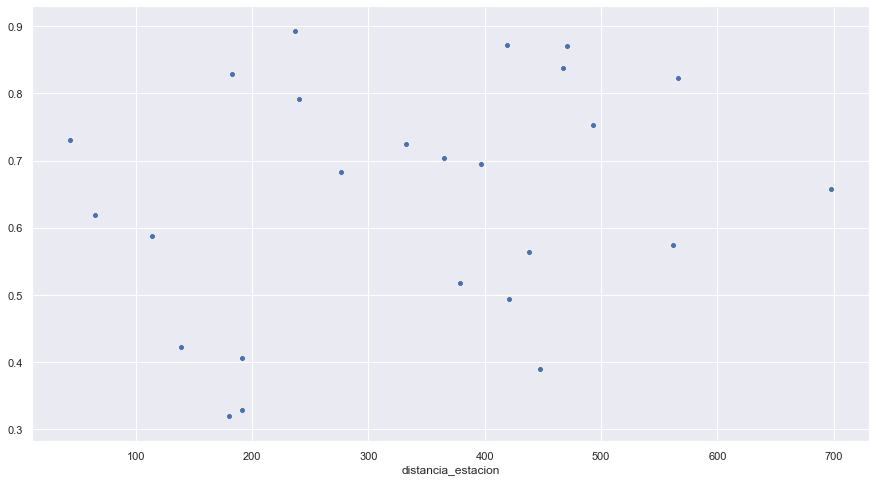

In [84]:
sns.scatterplot(x=datos_ncep_ncar_info['distancia_estacion'], y = histograma_max_mean_error )

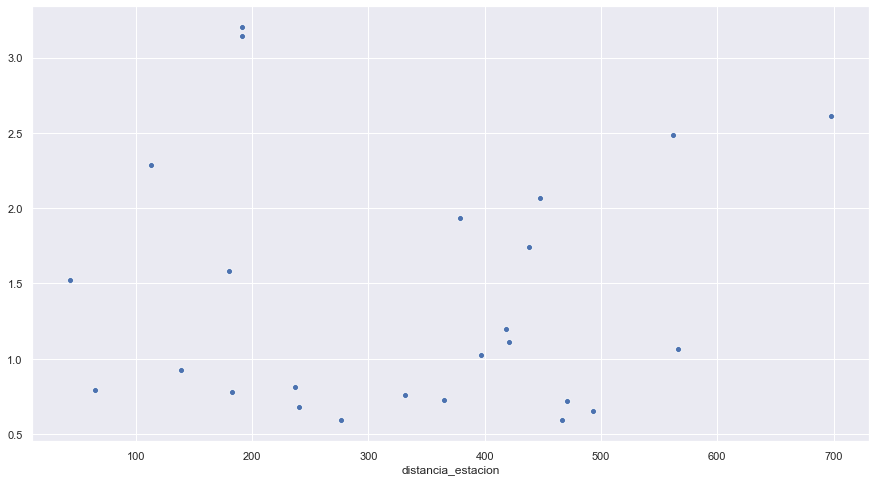

In [85]:
sns.scatterplot(x=datos_ncep_ncar_info['distancia_estacion'], y = histograma_np95_mean_error )

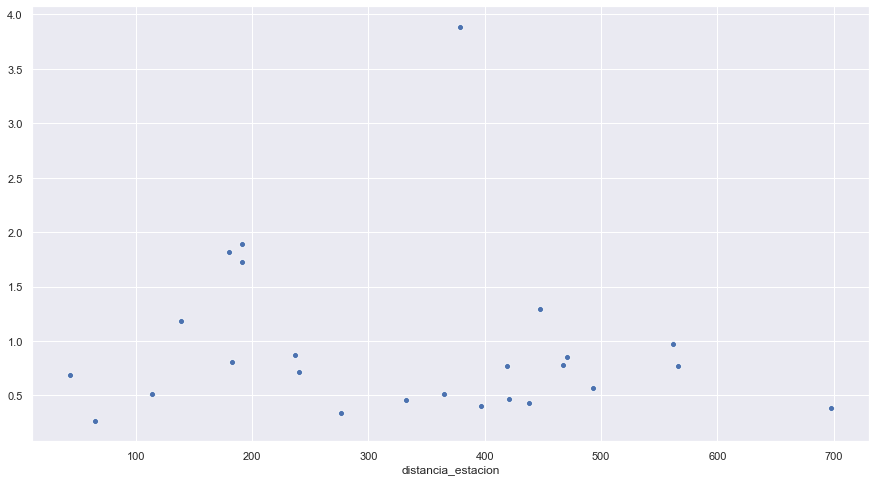

In [86]:
sns.scatterplot(x=datos_ncep_ncar_info['distancia_estacion'], y = histograma_anuales_mean_error )

No se observa ningún patrón entre la cercanía a la estación y coeficiente de pearson o el error porcentual promedio en los datos del modelo respecto a los de la estación más cercana

In [41]:
mapa_noa = folium.Map(location=[-28, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [42]:
for idx, (estacion, _prov, _org, coordenadas, *_) in estaciones_info.iterrows():
    lat, lon = coordenadas.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=estacion, icon=folium.Icon(color='red'))
    marker.add_to(mapa_noa)

In [43]:
for idx, (lat, lon,_,_) in datos_ncep_ncar_info.iterrows():
    marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, popup = 'p_anuales:'+str('{:1.2f}'.format(pearsons_anuales[idx][0])) + ' p_max:'+str('{:1.2f}'.format(pearsons_max[idx][0])) + ' p_np95:'+str('{:1.2f}'.format(pearsons_np95[idx][0])),fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
    marker.add_to(mapa_noa)


In [44]:
mapa_noa

Calculamos ahora el coeficiente de pearson, tomando k estaciones más cercanas y pesando su serie de tiempo por la distancia

In [45]:
def k_nearest(v, est, k):
    nearest = {}
    for index, row in v.iterrows():
        estaciones = est.copy()
        coords_1 = row[['LATITUD (°S)', 'LONGITUD (°W)']].values
        dist = {}
        for estation in est.iterrows():
           # print(estation[1][3].split(","))
            coords_2 = estation[1][3].split(",")
            dist[geopy.distance.vincenty(coords_1, coords_2).km] = estation[1][0]
        lst = dist.keys()
        nearest[index] = [[dist[i],i] for i in sorted(lst)[:k]]

    return nearest                

In [46]:
def pearson_pesado(df_estaciones, df_v, estaciones_cercanas):
    p = {}
    
    for v in df_v.keys():
        peso_total = 0
        v_serie_pesada = pd.DataFrame([0]*len(df_v.index), columns = ['serie pesada'], index =  df_v.index)
        for est_cercana in estaciones_cercanas[v]:
            if est_cercana[0]!='Miraflores':
                v_serie_pesada['serie pesada']= v_serie_pesada['serie pesada'].add(df_estaciones[est_cercana[0]]*est_cercana[1])
                peso_total+= est_cercana[1]
        v_serie_pesada/=peso_total
        aux = {}
        v_serie_pesada = v_serie_pesada.join(df_v[v])
        v_serie_pesada = v_serie_pesada.dropna()
        if len(v_serie_pesada[v].values)>=10:
            p[v] = pearsonr(v_serie_pesada[v], v_serie_pesada['serie pesada'])
    return p
    

In [47]:
estaciones_cercanas = k_nearest(datos_ncep_ncar_info, estaciones_info, 3)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  # Remove the CWD from sys.path while we load stuff.


In [48]:
pearsons_pesados_anuales = pearson_pesado(estaciones_anuales, datos_ncep_ncar_total, estaciones_cercanas)

In [49]:
histograma_pearson_pesados_anuales = []
histograma_pearson_anuales_cercanos = []
distances = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histograma_pearson_anuales_cercanos.append(pearsons_anuales[key][0])
    histograma_pearson_pesados_anuales.append(pearsons_pesados_anuales[key][0])
    distances.append(datos_ncep_ncar_info.loc[key][3])

Se calcularon los coeficientes de pearson pesadando las time series por la distancia al punto,usando **1 y 3 vecinos más cercanos** para los puntos de la grilla mostrados a continuación, para los cuales tiene más sentido este cálculo

In [50]:
mapa_noa = folium.Map(location=[-27, -65], zoom_start=5, width=600, height=500,  tiles='Stamen Terrain')

In [51]:
for idx, (estacion, _prov, _org, coordenadas, *_) in estaciones_info.iterrows():
    lat, lon = coordenadas.split(',')
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip=estacion, icon=folium.Icon(color='red'))
    marker.add_to(mapa_noa)

In [52]:
for idx, (lat, lon,_,_) in datos_ncep_ncar_info.iterrows():
    if idx in keys:
        marker = folium.CircleMarker(location=[-float(lat), -float(lon)], radius=5, tooltip=idx, popup = 'p_anuales:'+str('{:1.2f}'.format(pearsons_anuales[idx][0])) + ' p_max:'+str('{:1.2f}'.format(pearsons_max[idx][0])) + ' p_np95:'+str('{:1.2f}'.format(pearsons_np95[idx][0])),fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
        marker.add_to(mapa_noa)
mapa_noa

A continuación se muestra un lollipop plot de los valores de pearson obtenidos con 1 y 3 vecinos para los puntos antes indicados, además se indica la distancia a la estación más cercana

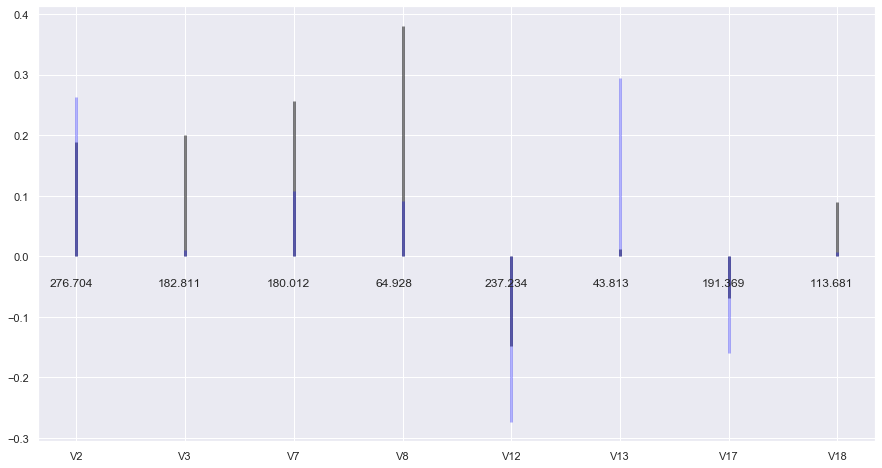

In [87]:
plt.vlines(ymin = 0, ymax = histograma_pearson_pesados_anuales, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histograma_pearson_anuales_cercanos, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))

Se observa que en general el coeficiente de pearson se vuelve más positivo, sin embargo se observa el caso anómalo de **V13**, y esto se puede explicar observando el mapa mostrado a continuación 

In [54]:
mapa_noa = folium.Map(location=[-25, -65], zoom_start=7, width=600, height=500,  tiles='Stamen Terrain')
for i in estaciones_cercanas['V13']:
    lat, lon = estaciones_info[estaciones_info['Estacion'] == i[0]]['LAT (S), LONG (W)(º)'].values[0].split(",")
    marker = folium.Marker(location=[-float(lat), -float(lon)], tooltip = i[0], icon=folium.Icon(color='red'))
    marker.add_to(mapa_noa)

marker = folium.CircleMarker(location=[-float(datos_ncep_ncar_info['LATITUD (°S)']['V13']), -float(datos_ncep_ncar_info['LONGITUD (°W)']['V13'])], radius=5, tooltip='V13',fill = True, icon=folium.Icon(color='green'), fillOpacity = 0.8)
marker.add_to(mapa_noa)

mapa_noa

Si se tiene en cuenta 3 vecinos más cercanos del punto **V13** se toman datos de las estaciones *San Luis* y *Caimancito*, los cuales se encuentran en direcciones opuestas, por lo que se aumenta la variabilidad de los datos, disminuyendo el coeficiente de pearson. Se observa además que la estación de *Miraflores* se encuentra lo suficientemente cerca, por lo que tomando solo esta medición el coeficiente de pearson es mayor.

Se observa también un aumento del coeficiente de pearson para los valores de máximos mostrado a continuación

In [67]:
pearsons_pesados_np95= pearson_pesado(estaciones_maximos, datos_ncep_ncar_maximo, estaciones_cercanas)
histograma_pearson_pesados_np95= []
histograma_pearson_np95_cercanos = []
keys = ['V2','V3','V7','V8', 'V12', 'V13', 'V17', 'V18']
for key in keys:
    histograma_pearson_np95_cercanos.append(pearsons_np95[key][0])
    histograma_pearson_pesados_np95.append(pearsons_pesados_np95[key][0])

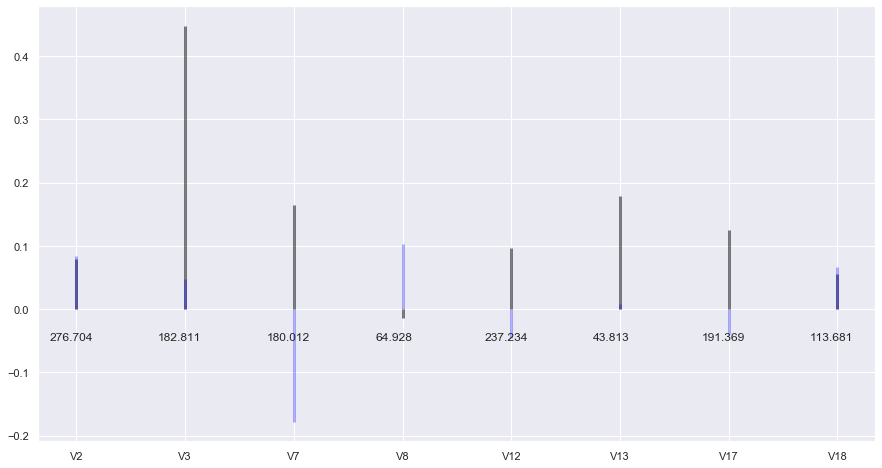

In [88]:
plt.vlines(ymin = 0, ymax = histograma_pearson_pesados_np95, x = keys, color='black' ,linewidth=3, alpha =0.5)
plt.vlines(ymin = 0, ymax = histograma_pearson_np95_cercanos, x = keys, color='blue' ,linewidth=3, alpha =0.3)
x = [-0.25, 0.75, 1.75,2.75,3.75,4.75,5.75, 6.75, 7.75]
for i in range(len(distances)): 
    plt.text(x[i], y = -0.05,s= '{:.3f}'.format(distances[i]))